<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/SuperMarioBros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SuperMarioBros openAI gym 環境などのインストール

- gmy-super-mario-bros
- wandb
- 自作ライブラリ

wandb のアカウントを持っていることが前提です。

In [1]:
!wget https://raw.githubusercontent.com/aquapathos/MLLesson/master/mksmb_env.py -q
!pip install gym-super-mario-bros > /dev/null
!pip install wandb > /dev/null
!pip install stable-baselines3 > /dev/null

このインストール過程で、[nes-py](https://github.com/Kautenja/nes-py) というファミコンエミュレータがインストールされる模様。

モデルを保存するために Google Drive をマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 動作確認

USEW False
USEW False
USEW False
USEW False


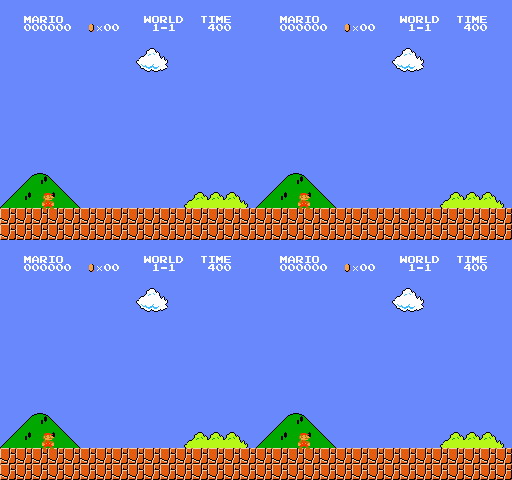

In [3]:
import gym,cv2

import gym_super_mario_bros
from mksmb_env import Joy,make_mario_env,recordModelCallback
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT,COMPLEX_MOVEMENT,RIGHT_ONLY
from stable_baselines3.common.vec_env import DummyVecEnv,SubprocVecEnv,VecFrameStack

env_id = 'SuperMarioBros-v0'
#env = make_mario_env(env_id, n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir= "test")
env = make_mario_env(Joy(), n_envs=4, seed=0,vec_env_cls=DummyVecEnv, monitor_dir= "test")
env = VecFrameStack(env, n_stack=4)

from PIL import Image 
Image.fromarray((env.render(mode='rgb_array')))

スーパーマリオのアクションスペースは256種ものアクションがあり、[JoypadSpace() ](https://github.com/Kautenja/nes-py/blob/master/nes_py/wrappers/joypad_space.py))というラッパーを通すと7種に減ることがわかる。[JoypadSpace() ](https://github.com/Kautenja/nes-py/blob/master/nes_py/wrappers/joypad_space.py)のソースを見ると、

```
    # a mapping of buttons to binary values
    _button_map = {
        'right':  0b10000000,
        'left':   0b01000000,
        'down':   0b00100000,
        'up':     0b00010000,
        'start':  0b00001000,
        'select': 0b00000100,
        'B':      0b00000010,
        'A':      0b00000001,
        'NOOP':   0b00000000,
    }
```
とあり、

```
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
```

は、[actions.py](https://github.com/Kautenja/gym-super-mario-bros/blob/1a3dde897700614f729fc3294c1e451528d9a112/gym_super_mario_bros/actions.py)で、

```
# actions for very simple movement
SIMPLE_MOVEMENT = [
    ['NOOP'],
    ['right'],
    ['right', 'A'],
    ['right', 'B'],
    ['right', 'A', 'B'],
    ['A'],
    ['left'],
]
```
と定義されている。基本的にスーパーマリオは右スクロールのゲームなので、これでもよさげだが、左ジャンプぐらいもやはりほしい。upは NOOPと同じなので省いて、次のアクションスペースを使ってみる。

In [4]:
MYACTIONSET = [
    ['NOOP'],
    ['right'],
    ['right', 'A'],
    ['right', 'B'],
    ['right', 'A', 'B'],
    ['A'],
    ['left'],
    ['left', 'A'],
    ['left', 'B'],
    ['left', 'A', 'B'],
    ['down'],
]

ゲーム画面のサイズは

In [5]:
gym_super_mario_bros.make('SuperMarioBros-v0').reset().shape

(240, 256, 3)

# PPO学習

In [6]:
from stable_baselines3.common.vec_env import DummyVecEnv,SubprocVecEnv,VecFrameStack,VecEnv
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import wandb,os
import numpy as np
import torch,gym
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(repr(device))

device(type='cuda', index=0)


In [7]:
log_dir ='/content/drive/MyDrive/M/smb'

# Inside my model training code 
!export WANDB_NOTEBOOK_NAME="Mario".ipynb"
import wandb
PROJECTNAME='Mario'
wandb.init(project=PROJECTNAME)

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


wandb: Currently logged in as: aquapathos (use `wandb login --relogin` to force relogin)


In [ ]:
monargs={'usewandb':True}
#env = make_mario_env(Joy(movement=MYACTIONSET), n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir=log_dir,monitor_kwargs=monargs)
env = make_mario_env(Joy(movement=MYACTIONSET), n_envs=8, seed=0,vec_env_cls=DummyVecEnv, monitor_dir= log_dir,monitor_kwargs=monargs)
env = VecFrameStack(env, n_stack=4)

model = PPO('CnnPolicy', env, verbose=0,device=device,        
    learning_rate = 3e-4,  # default  3e-4
    n_steps = 2048, # 2048
    clip_range = 0.2, # default 0.2
    ent_coef = 0.01, # default 0.01
    batch_size = 64, #64
    n_epochs = 4 ) # 4

# model.load('/content/drive/MyDrive/M/smb/best_model.zip')
callback = recordModelCallback(check_freq=50, log_dir=log_dir, usewandb=True)
total_timesteps = 1e8
%time model.learn(total_timesteps=total_timesteps,callback=callback)

USEW True
USEW True
USEW True
USEW True
USEW True
USEW True
USEW True
USEW True
Num timesteps: 4400 : Best mean reward: 0.00 - Last mean reward/ep: 314.00
Saving new best model to /content/drive/MyDrive/M/smb/best_model.zip
Num timesteps: 4800 : Best mean reward: 314.00 - Last mean reward/ep: 314.00
Num timesteps: 5200 : Best mean reward: 314.00 - Last mean reward/ep: 314.00
Num timesteps: 5600 : Best mean reward: 314.00 - Last mean reward/ep: 314.00
Num timesteps: 6000 : Best mean reward: 314.00 - Last mean reward/ep: 314.00
Num timesteps: 6400 : Best mean reward: 314.00 - Last mean reward/ep: 314.00
Num timesteps: 6800 : Best mean reward: 314.00 - Last mean reward/ep: 314.00
Num timesteps: 7200 : Best mean reward: 314.00 - Last mean reward/ep: 314.00
Num timesteps: 7600 : Best mean reward: 314.00 - Last mean reward/ep: 252.00
Num timesteps: 8000 : Best mean reward: 314.00 - Last mean reward/ep: 252.00
Num timesteps: 8400 : Best mean reward: 314.00 - Last mean reward/ep: 252.00
Num ti

In [9]:
!rm /content/drive/MyDrive/M/smb/?.moni*